In [349]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, Literal
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
import os
from pydantic import BaseModel, Field
import operator

In [350]:
load_dotenv()
api_key = os.getenv("GEMINI_API_KEY")

In [351]:
class GenerateSchema(BaseModel) :
    tweet :str = Field(description="twitter post")

class EvaluateSchema(BaseModel) :
    evaluation : Literal["approved", "needs_improvement"] = Field(description="final result of evaluation")
    feedback : str = Field(description="write a feedback on the tweet")

class OptimizeSchema(BaseModel):
    tweet :str = Field(description="twitter post based on the tweet provided and feedback")

In [352]:
model = ChatGoogleGenerativeAI(
    model= "gemini-2.5-flash",
    temperature=1.0,
    max_retries=2,
    google_api_key=api_key,
)
tweetmodel = model.with_structured_output(GenerateSchema)
evaluationmodel = model.with_structured_output(EvaluateSchema)
optimizemodel = model.with_structured_output(OptimizeSchema)

In [353]:
class BotState(TypedDict) :
    topic : str
    tweet : str
    evaluation : Literal["approved", "needs_improvement"]
    feedback : str
    iteration : int
    max_iterations : int


In [354]:
def generate_post(state: BotState) :
    print("gen")
    
    topic = state["topic"]
    prompt = f"""You are a funny and clever Twitter/X influencer
    Write a short, original, and hilarious tweet on the topic: "{topic}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
    """
    prompt = f"""write a funny tweet on topic {topic}
"""
    reply = tweetmodel.invoke(prompt)
    state["tweet"] = reply.tweet
    state["iteration"] = 0
    state["max_iterations"] = 2
    print(state["tweet"])
    return state

def evaluate_post(state: BotState):
    print("eval")
    
    prompt = f"""You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format
    Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 200 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)
 """
    reply = evaluationmodel.invoke(prompt)
    state["evaluation"] = reply.evaluation
    state["feedback"] = reply.feedback
    print(reply)
    return state

def optimize_post(state : BotState):
    print("opt")
    
    prompt= f"""You punch up tweets for virality and humor based on given feedback.
    Improve the tweet based on this feedback
        original tweet : {state["tweet"]}
        topic : {state["topic"]}
        feedback : {state["feedback"]}
   
    """
    reply = optimizemodel.invoke(prompt)
    state["tweet"] = reply.tweet
    iteration = state['iteration'] + 1

    # iterations = state["iterations"] 
    state["iteration"] = iteration
    print(reply)
    return state

def route_evaluation(state: BotState):

    if state['evaluation'] == 'approved' or state["iteration"]>state["max_iterations"]:
        return 'approved'
    else:
        return 'needs_improvement'
    
    
    
    


In [355]:
graph = StateGraph(BotState)

# add nodes
graph.add_node("generate_post", generate_post)
graph.add_node("evaluate_post", evaluate_post)
graph.add_node("optimize_post", optimize_post)

# add edges
graph.add_edge(START, "generate_post")
graph.add_edge("generate_post", "evaluate_post")
graph.add_conditional_edges('evaluate_post', route_evaluation, {'approved': END, 'needs_improvement': 'optimize_post'})
graph.add_edge("optimize_post", "evaluate_post")

# compile graph
workflow = graph.compile()

In [356]:
initial_state = {
    "topic" : "btech grads"
}
final_state = workflow.invoke(initial_state)
print(final_state)

gen
B.Tech grads are like fine wine, they only get better with age... and by 
eval
evaluation='needs_improvement' feedback='The tweet is an incomplete thought, cutting off mid-sentence. It reads like a traditional joke setup without a punchline, which violates the format rules. As it stands, it lacks humor, originality, and virality, and is poorly formatted.'
opt
tweet='B.Tech grads are like fine wine, they only get better with age... and by finally landing a job that pays enough to *buy* fine wine.'
eval
evaluation='approved' feedback='Another "fine wine" analogy? Groundbreaking. Yet, the twist about actually affording the wine does salvage a chuckle, making it marginally less predictable than your average LinkedIn post. It\'s concise enough to hold attention and likely to resonate with the perpetually underpaid B.Tech demographic, ensuring a modest ripple of retweets. Format-wise, it\'s a tweet, not a novel, which is commendable given the low bar. Not a masterpiece, but it avoids imm

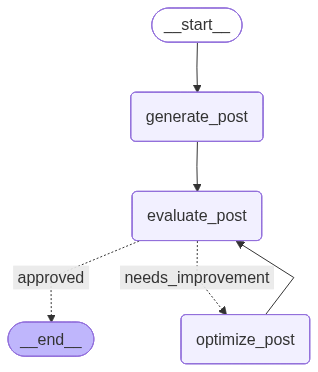

In [357]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())